In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

from math import sqrt
from sqlalchemy import Index
import warnings

In [3]:
train_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/train.csv')
features_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv')
stores_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')
test_df = pd.read_csv('/kaggle/input/walmart-sales-forecast/test.csv')
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train_df.shape

(421570, 5)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [6]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [7]:
train_df.isnull().head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


In [8]:
dataset= features_df.merge(stores_df, how='inner', on='Store')
dataset.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [9]:
from datetime import datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [10]:
dataset['Week'] = dataset.Date.dt.isocalendar().week # for the week data
dataset['Year'] = dataset.Date.dt.isocalendar().year # for the year data

dataset.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,9,2010


Merging with train_df

In [11]:
train_merge = train_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

Merging with test_df

In [12]:
test_merge = test_df.merge(dataset, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

**function to plot the scatter plot for various relationships.**

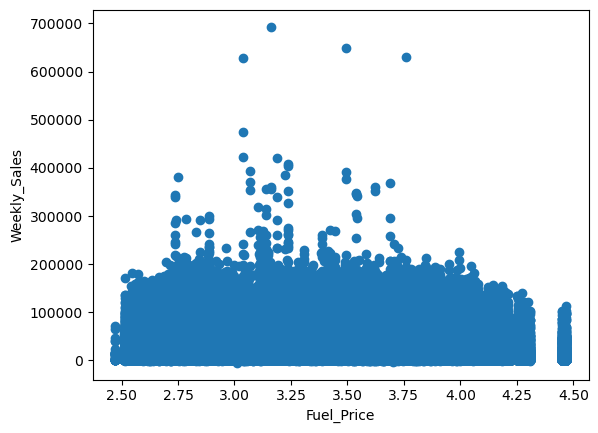

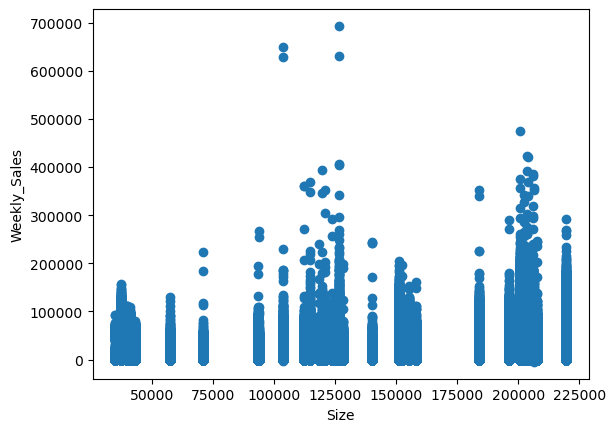

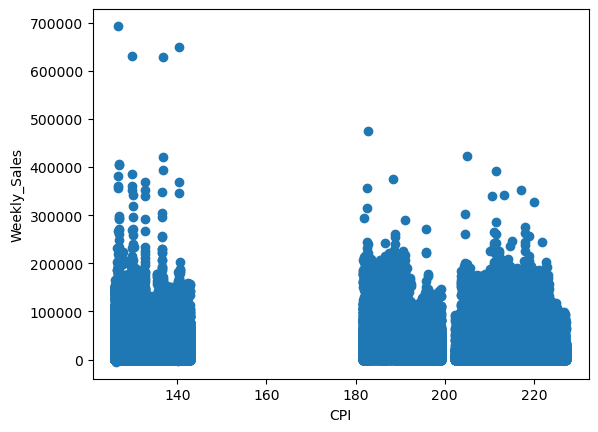

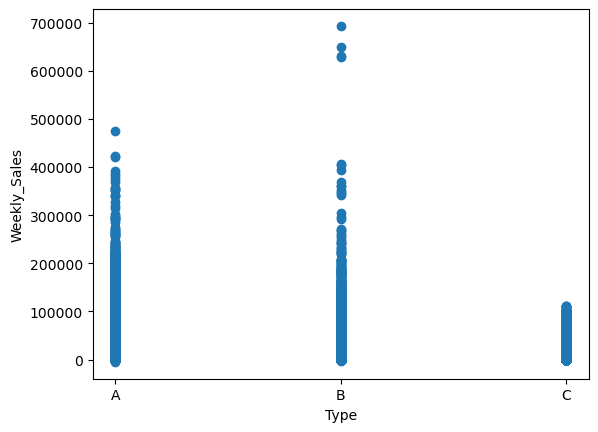

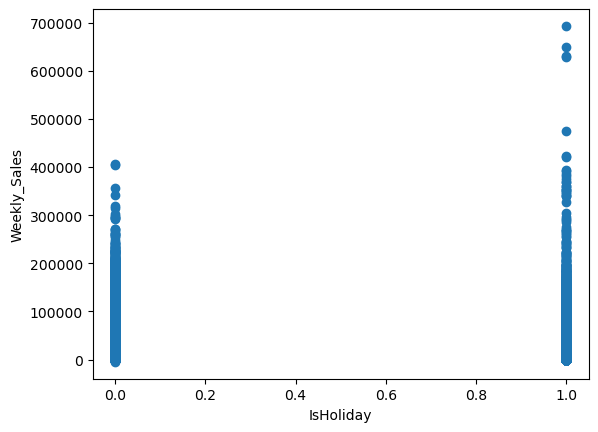

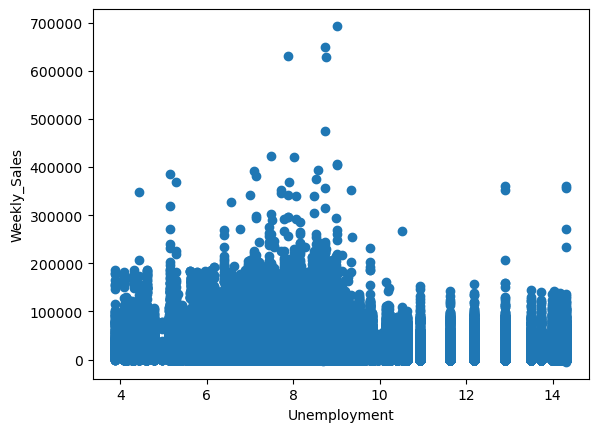

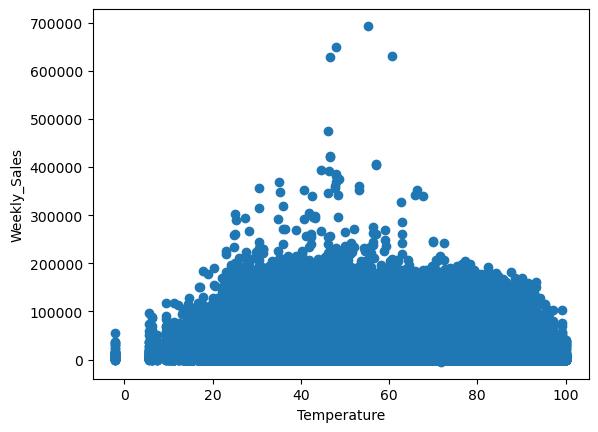

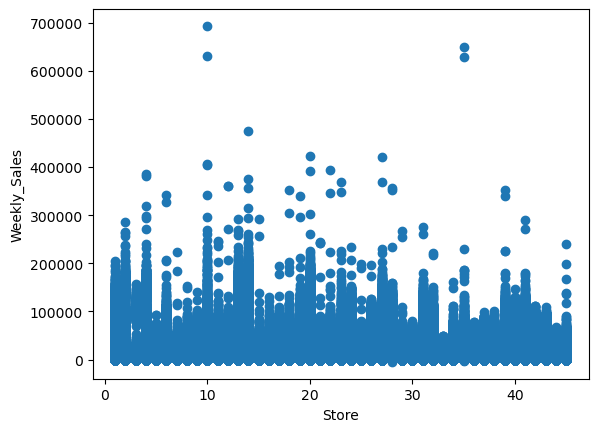

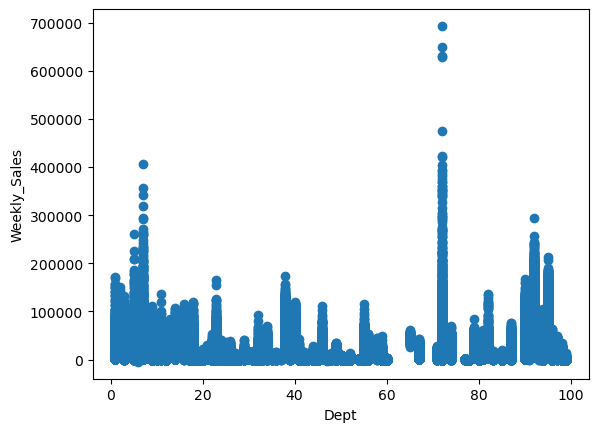

In [13]:
def scatter(train_merge, column):
    plt.figure()
    plt.scatter(train_merge[column] , train_merge['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)

scatter(train_merge, 'Fuel_Price')  # with respect to Fuel_Price
scatter(train_merge, 'Size')  # with respect to Size
scatter(train_merge, 'CPI')  # with respect to CPI
scatter(train_merge, 'Type')  # with respect to Type
scatter(train_merge, 'IsHoliday') # with respect to IsHoliday
scatter(train_merge, 'Unemployment')  # with respect to Unemployment
scatter(train_merge, 'Temperature') # with respect to Temperature
scatter(train_merge, 'Store') # with respect to Store
scatter(train_merge, 'Dept')  # with respect to Dept

**Average Weekly Sales for the year 2010**

<AxesSubplot:>

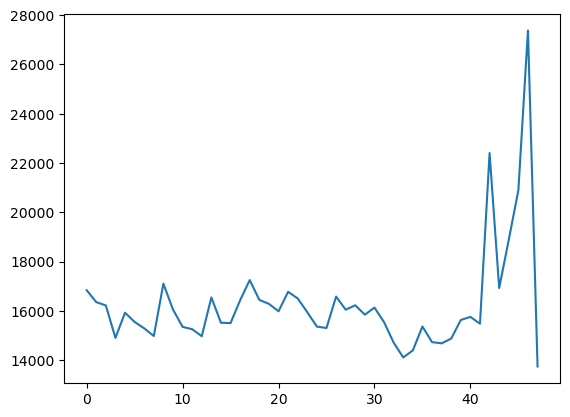

In [14]:
weekly_sales_2010 = train_merge[train_merge['Year']==2010]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(weekly_sales_2010.values) # for plotting then lineplot

**Average Weekly Sales for the year 2011**

<AxesSubplot:>

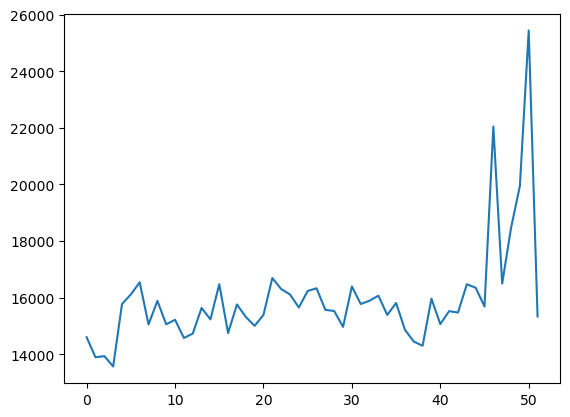

In [15]:
weekly_sales_2011 = train_merge[train_merge['Year']==2011]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(weekly_sales_2011.values) # for plotting then lineplot

**Average Weekly Sales for the year 2012**

<AxesSubplot:>

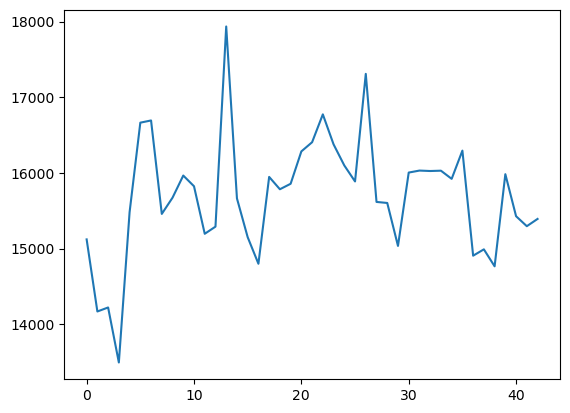

In [16]:
weekly_sales_2012 = train_merge[train_merge['Year']==2012]['Weekly_Sales'].groupby(train_merge['Week']).mean()

sns.lineplot(weekly_sales_2012.values) # for plotting then lineplot

Plotting the above three plots together

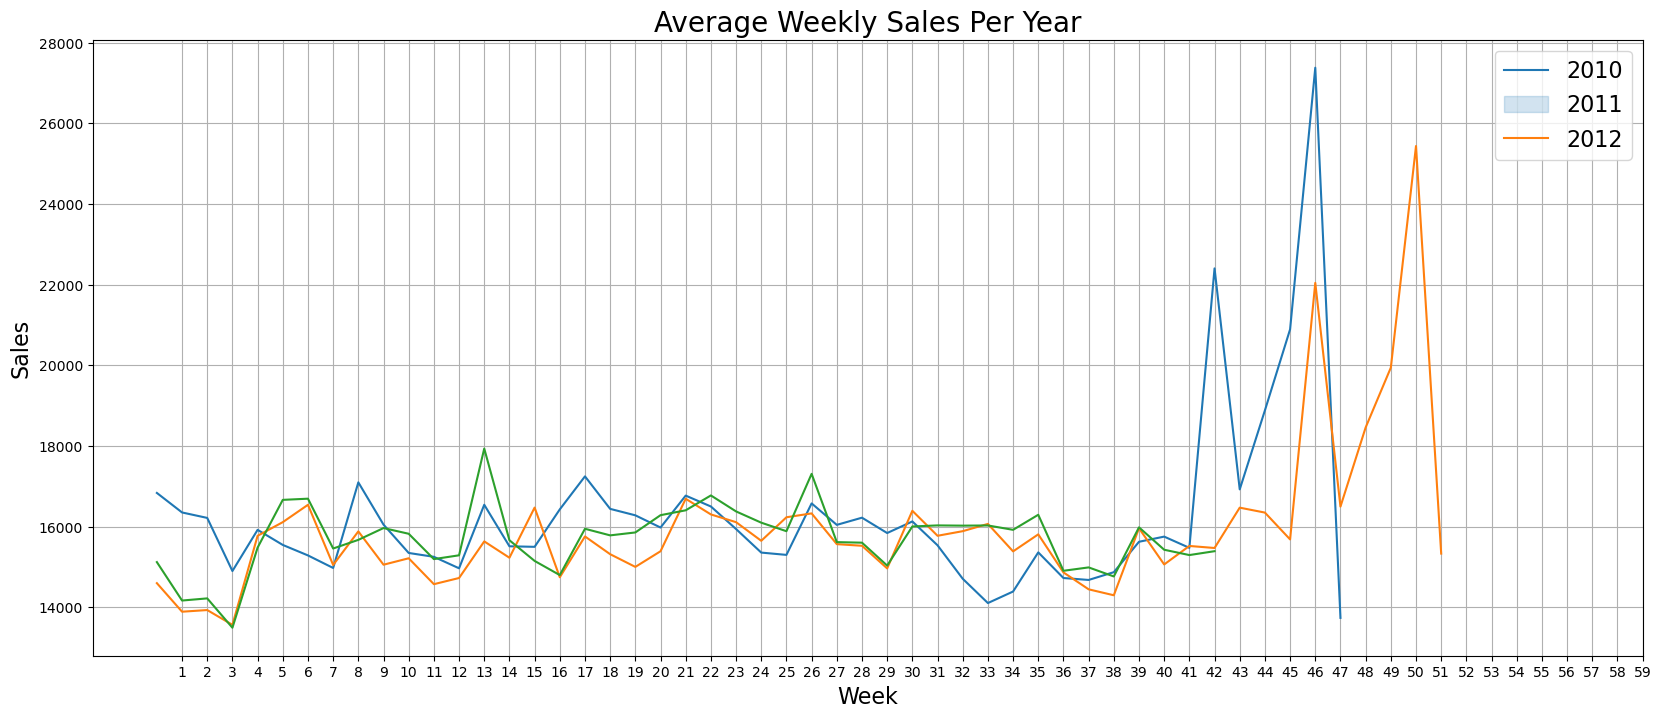

In [17]:
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1,60, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales Per Year', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()